In [1]:
import os
import pandas
import numpy
import math
import matplotlib
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Settings
filename = "MA_Public_Schools_2017.csv"
start_year = 2010
stop_year = 2017
y_column_name = "% Graduated"
y_groups = 2
ignore_columns = [
    "High School Graduates (#)",
    "% Dropped Out",
    "% Still in School",
    "School Code",
    "School Name",
    "Contact Name",
    "Address 1",
    "Address 2",
    "Town",
    "State",
    "Zip",
    "Phone",
    "Fax",
    "District Name",
    "% Still in School",
    "% Non-Grad Completers",
    "% GED",
    "% Dropped Out",
    "% Permanently Excluded",
    "High School Graduates (#)",
    "Attending Coll./Univ. (#)",
    "Accountability and Assistance Description",
    "District_Accountability and Assistance Description",
]
one_hot_encode = ["School Type", "Function"]
floatify_columns = ["AP_Test Takers", "AP_Tests Taken"]
levelize_columns = ["Accountability and Assistance Level", "District_Accountability and Assistance Level"]
gradify_columns = ["Grade"]

In [3]:
# Load the data
df = pandas.read_csv(filename)

In [4]:
df

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,Pioneer Charter School of Science II (PCSS-II),Charter School,Principal,Vahit Sevinc,97 Main Street,NaN,Saugus,MA,1906,...,30.0,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1857,35100205,Springfield Preparatory Charter School,Charter School,Principal,Bill Spirer,370 Pine St.,NaN,Springfield,MA,1105,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1858,39020900,TEC Connections Academy Commonwealth Virtual S...,Public School,Principal,Adam Goldberg,141 Mansion Drive,NaN,East Walpole,MA,2032,...,28.0,Level 3,Very low assessment participation (Less than 90%),NaN,NaN,NaN,Level 3,Very low assessment participation (Less than 90%),NaN,NaN
1859,35050405,UP Academy Charter School of Dorchester,Charter School,Principal,Jabari Peddie,35 Westville Street,NaN,Boston,MA,2124,...,NaN,Level 1,Meeting gap narrowing goals,35.0,92.0,98.0,Level 1,Meeting gap narrowing goals,92.0,98.0


In [5]:
for column in df.columns:
    print(column)

School Code
School Name
School Type
Function
Contact Name
Address 1
Address 2
Town
State
Zip
Phone
Fax
Grade
District Name
District Code
PK_Enrollment
K_Enrollment
1_Enrollment
2_Enrollment
3_Enrollment
4_Enrollment
5_Enrollment
6_Enrollment
7_Enrollment
8_Enrollment
9_Enrollment
10_Enrollment
11_Enrollment
12_Enrollment
SP_Enrollment
TOTAL_Enrollment
First Language Not English
% First Language Not English
English Language Learner
% English Language Learner
Students With Disabilities
% Students With Disabilities
High Needs
% High Needs
Economically Disadvantaged
% Economically Disadvantaged
% African American
% Asian
% Hispanic
% White
% Native American
% Native Hawaiian, Pacific Islander
% Multi-Race, Non-Hispanic
% Males
% Females
Total # of Classes
Average Class Size
Number of Students
Salary Totals
Average Salary
FTE Count
In-District Expenditures
Total In-district FTEs
Average In-District Expenditures per Pupil
Total Expenditures
Total Pupil FTEs
Average Expenditures per Pupil
# i

In [6]:
df.isna().sum().sum()

380677

In [7]:
df_encoded = df.copy()

In [8]:
numpy.array(df_encoded["School Type"]).reshape(-1, 1)

array([['Public School'],
       ['Public School'],
       ['Public School'],
       ...,
       ['Public School'],
       ['Charter School'],
       ['Charter School']], dtype=object)

In [9]:
for column_name in one_hot_encode:
    encoder = OneHotEncoder(sparse=False)
    column = numpy.array(df_encoded[column_name][df_encoded[column_name].notna()]).reshape(-1, 1)
    encoder.fit(column)
    indices = df_encoded[column_name][df_encoded[column_name].notna()].index
    for i in range(len(encoder.categories_[0])):
        new_column_name = column_name + ": " + encoder.categories_[0][i]
        df_encoded = pandas.merge(df_encoded, pandas.DataFrame({new_column_name: encoder.transform(column)[:, i]}), left_index = True, right_index = True)
    df_encoded = df_encoded.drop(column_name, 1)

In [10]:
# Fix Data
df_clean = df_encoded

for column in floatify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is str:
            df_clean.loc[row, column] = float(df_clean.loc[row, column].replace(',', ''))

for column in levelize_columns:
    for row in range(df_clean.shape[0]):
        value = df_clean.loc[row, column]
        if value == "Insufficient data":
            df_clean.loc[row, column] = numpy.nan
        elif value == "Level 1":
            df_clean.loc[row, column] = 1
        elif df_clean.loc[row, column] == "Level 2":
            df_clean.loc[row, column] = 2
        elif df_clean.loc[row, column] == "Level 3":
            df_clean.loc[row, column] = 3
        elif df_clean.loc[row, column] == "Level 4":
            df_clean.loc[row, column] = 4
        elif df_clean.loc[row, column] == "Level 5":
            df_clean.loc[row, column] = 5

grades = ["PK", "K", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

for grade in grades:
    df_clean["Grade " + grade] = numpy.full(df_clean.shape[0], 0)

for column in gradify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is not float:
            for current_grade in df_clean.loc[row, column].replace("0", "").split(","):
                df_clean.loc[row, "Grade " + current_grade] = 1

    df_clean = df_clean.drop(column, 1)

In [11]:
df_clean.isna().sum().sum()

380929

In [12]:
# Columns that were removed
for column in df.columns:
    if column not in df_clean.columns:
        print(column)

School Type
Function
Grade


In [13]:
# Get rid of errored/confusing data
df_slim = df_clean
for column in ignore_columns:
    if column in df_slim.columns:
        df_slim = df_slim.drop(column, 1)

In [14]:
df_slim.shape

(1861, 296)

In [15]:
df[y_column_name].describe()

count    376.000000
mean      83.327394
std       21.459396
min        0.000000
25%       82.150000
50%       92.250000
75%       96.200000
max      100.000000
Name: % Graduated, dtype: float64

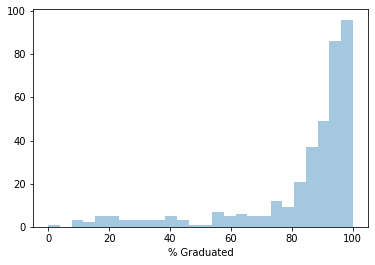

In [16]:
seaborn.distplot(df[y_column_name][df[y_column_name].notna()], kde=False)

In [17]:
df[y_column_name].isna().sum() / df.shape[0]

0.7979580870499732

In [18]:
df_fixed_y_column = df_slim[df_slim[y_column_name].notna()]
df_fixed_y_column.shape

(376, 296)

In [19]:
df_fixed_y_column[y_column_name] = OrdinalEncoder().fit_transform(numpy.array(df_fixed_y_column[y_column_name] > df_fixed_y_column[y_column_name].mean()).reshape(-1, 1))
df_fixed_y_column[y_column_name]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0       1.0
8       1.0
16      1.0
17      0.0
23      1.0
       ... 
1826    0.0
1831    1.0
1838    1.0
1851    0.0
1858    0.0
Name: % Graduated, Length: 376, dtype: float64

In [20]:
accuracy_scores = []
jaccard_scores = []
aggregated_feature_importances = {}

for column in df_fixed_y_column.columns:
    if column != y_column_name:
        aggregated_feature_importances[column] = 0

number_of_bootstraps = 100
for run in range(number_of_bootstraps):
    print("Run {0}".format(run))
    
    # Split X and Y
    x = df_fixed_y_column.drop(y_column_name, 1)
    y = df_fixed_y_column[y_column_name]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    # Recombine the X and Y of the training data
    df_train = pandas.merge(pandas.DataFrame(x_train), pandas.DataFrame(y_train), left_index=True, right_index=True)
    
    # Balance the groups in the training data (with resampling)
    lengths = []
    for group_index in range(y_groups):
        group_1_len = df_train[df_train[y_column_name] == 1].shape[0]
    df_train = pandas.concat([
        df_train[df_train[y_column_name] == 1],
        resample(df_train[df_train[y_column_name] == 0], n_samples=group_1_len)
    ])
    
    # Resplit X and Y
    x_train = df_train.drop(y_column_name, 1)
    y_train = df_train[y_column_name]
    
    # Create the pipeline
    imputer = IterativeImputer()
    scaler = RobustScaler()
    selector = SelectFromModel(RidgeClassifierCV())
    model = AdaBoostClassifier()
    pipeline = Pipeline(steps=[
        ("imputer", imputer),
    #     ("scaler", scaler),
        ("selector", selector),
        ("model", model)
    ])
    
    # Pipeline Classification
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    
    # Accuracy Score
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Jaccard Score
    jaccard_scores.append(jaccard_score(y_test, y_pred))
    
    # Feature Importances
    for index in range(len(model.feature_importances_)):
        column = x_train.columns[index]
        importance = model.feature_importances_[index]
        aggregated_feature_importances[column] += importance

Run 0
Run 1
Run 2
Run 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 4
Run 5
Run 6
Run 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 8
Run 9
Run 10
Run 11
Run 12
Run 13


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 24
Run 25
Run 26
Run 27
Run 28


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 29
Run 30


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 31
Run 32
Run 33
Run 34
Run 35
Run 36


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 37
Run 38


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 39


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 40


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 41
Run 42


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 43
Run 44


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 45
Run 46
Run 47
Run 48
Run 49
Run 50


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 51
Run 52
Run 53
Run 54
Run 55


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 56
Run 57
Run 58


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 59
Run 60
Run 61
Run 62


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 63
Run 64
Run 65
Run 66


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 67
Run 68
Run 69
Run 70


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 71
Run 72
Run 73
Run 74
Run 75


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 76


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 77
Run 78
Run 79
Run 80


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 81


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 82


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 83


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 84


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94
Run 95


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Run 96
Run 97
Run 98
Run 99


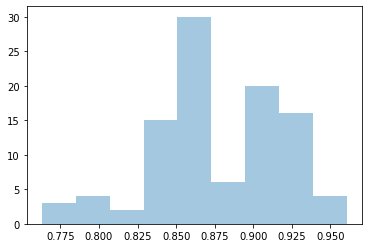

In [21]:
seaborn.distplot(accuracy_scores, kde=False)

In [22]:
accuracy = 0.95
partial_accuracy = (1-accuracy) / 2
accuracy_scores_sorted = sorted(accuracy_scores)
estimate = accuracy_scores_sorted[int(len(accuracy_scores_sorted) / 2)]
lower_ci = accuracy_scores_sorted[int(len(accuracy_scores_sorted) * partial_accuracy)]
upper_ci = accuracy_scores_sorted[int(len(accuracy_scores_sorted) * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.868 (0.776, 0.947)


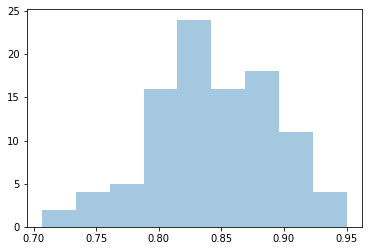

In [23]:
seaborn.distplot(jaccard_scores, kde=False)

In [24]:
accuracy = 0.95
partial_accuracy = (1-accuracy) / 2
jaccard_scores_sorted = sorted(jaccard_scores)
estimate = jaccard_scores_sorted[int(len(jaccard_scores_sorted) / 2)]
lower_ci = jaccard_scores_sorted[int(len(jaccard_scores_sorted) * partial_accuracy)]
upper_ci = jaccard_scores_sorted[int(len(jaccard_scores_sorted) * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.839 (0.735, 0.929)


In [25]:
for key, value in {k: v for k, v in sorted(aggregated_feature_importances.items(), key=lambda item: item[1], reverse=True)}.items():
    print("{0:<100.100}: {1:4.4f}".format(key, value))

3_Enrollment                                                                                        : 2.6800
2_Enrollment                                                                                        : 2.2200
4_Enrollment                                                                                        : 2.0400
% Females                                                                                           : 1.9000
1_Enrollment                                                                                        : 1.8800
Average Salary                                                                                      : 1.7800
FTE Count                                                                                           : 1.7600
Total Pupil FTEs                                                                                    : 1.7600
Salary Totals                                                                                       : 1.7600
% Males            

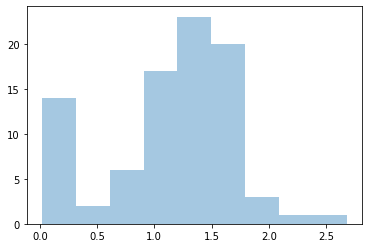

In [26]:
importances = []
for importance in aggregated_feature_importances.values():
    if importance != 0:
        importances.append(importance)
seaborn.distplot(importances, kde=False)